In [1]:
import sys
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import layers
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

module_path = '/home/kinfi4/python/Propaganda-Analyzer/src/ETL'
if module_path not in sys.path:
    sys.path.append(module_path)

from services.text_preprocessor import TextPreprocessor
from config.config import MAX_POST_LEN_IN_WORDS

In [2]:
NUMBER_OF_WORDS_TO_TOKENIZE = 10_000

In [3]:
def plot_hisory(history_dict: dict):
    plt.plot(history_dict['accuracy'])
    plt.plot(history_dict['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [4]:
def get_model_checkpoint_callback(filepath):
    return ModelCheckpoint(
        filepath,
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1
    )

In [5]:
preprocessor = TextPreprocessor()

df = pd.read_csv(
    '../../data/data.csv',
    names=['channel', 'text', 'date', 'type', 'sent']
)

df['text'] = df['text'].apply(preprocessor.preprocess_and_lemmatize)

In [6]:
tokenizer = Tokenizer(num_words=NUMBER_OF_WORDS_TO_TOKENIZE)
tokenizer.fit_on_texts(df['text'])

preprocessor = TextPreprocessor(keras_tokenizer=tokenizer)

In [7]:
pickle.dump(tokenizer, open('../trained-models/keras-tokenizer.pk', 'wb'))

In [8]:
text_sequences = preprocessor.keras_tokenize_and_pad_text(
    df['text'],
    make_preprocessing=True,
    max_words_number=MAX_POST_LEN_IN_WORDS,
    padding='pre',
    truncating='post',
)

In [9]:
df['type'] = pd.factorize(df['type'])[0]

In [10]:
categorical_types = to_categorical(df['type'])

In [11]:
x_train, x_test, y_train, y_test = train_test_split(
    text_sequences,
    categorical_types,
    test_size=0.2
)

# Building a LSTM model

In [12]:
lstm_model = Sequential([
    layers.Embedding(NUMBER_OF_WORDS_TO_TOKENIZE, 16, input_length=MAX_POST_LEN_IN_WORDS),
    layers.LSTM(32, recurrent_dropout=0.2),
    layers.Dense(4, activation='softmax')
])

In [13]:
lstm_model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
save_callback = get_model_checkpoint_callback('../trained-models/lstm-news-type-prediction.h5')
history = lstm_model.fit(
    x=x_train,
    y=y_train,
    epochs=15,
    batch_size=32,
    validation_split=0.1,
    callbacks=[save_callback]
)

Epoch 1/15
18/18 [==============================] - 6s 142ms/step - loss: 1.3832 - accuracy: 0.2508 - val_loss: 1.3661 - val_accuracy: 0.3279

Epoch 00001: val_accuracy improved from -inf to 0.32787, saving model to ../trained-models/lstm-news-type-prediction.h5
Epoch 2/15
18/18 [==============================] - 2s 95ms/step - loss: 1.3652 - accuracy: 0.3423 - val_loss: 1.3419 - val_accuracy: 0.4426

Epoch 00002: val_accuracy improved from 0.32787 to 0.44262, saving model to ../trained-models/lstm-news-type-prediction.h5
Epoch 3/15
18/18 [==============================] - 2s 95ms/step - loss: 1.3396 - accuracy: 0.4331 - val_loss: 1.2964 - val_accuracy: 0.5082

Epoch 00003: val_accuracy improved from 0.44262 to 0.50820, saving model to ../trained-models/lstm-news-type-prediction.h5
Epoch 4/15
18/18 [==============================] - 2s 108ms/step - loss: 1.2869 - accuracy: 0.4818 - val_loss: 1.2301 - val_accuracy: 0.4918

Epoch 00004: val_accuracy did not improve from 0.50820
Epoch 5/1

In [15]:
score = lstm_model.evaluate(x_test, y_test, verbose=0)

print(f'The accuracy of the model = {score[1]}')

The accuracy of the model = 0.8300653696060181


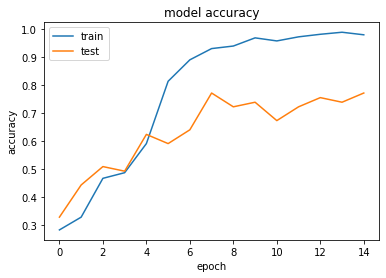

In [16]:
plot_hisory(history.history)

# Building CNN model

In [17]:
cnn_model = Sequential([
    layers.Embedding(NUMBER_OF_WORDS_TO_TOKENIZE, 8, input_length=MAX_POST_LEN_IN_WORDS),
    layers.Conv1D(250, 4, activation='relu', padding='valid'),
    layers.GlobalMaxPool1D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax')
])

In [18]:
cnn_model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
save_callback = get_model_checkpoint_callback('../trained-models/cnn-news-type-prediction.h5')
history = cnn_model.fit(
    x=x_train,
    y=y_train,
    epochs=15,
    batch_size=32,
    validation_split=0.1,
    callbacks=[save_callback]
)

Epoch 1/15
18/18 [==============================] - 1s 38ms/step - loss: 1.3792 - accuracy: 0.3097 - val_loss: 1.3531 - val_accuracy: 0.3279

Epoch 00001: val_accuracy improved from -inf to 0.32787, saving model to ../trained-models/cnn-news-type-prediction.h5
Epoch 2/15
18/18 [==============================] - 0s 28ms/step - loss: 1.3525 - accuracy: 0.3036 - val_loss: 1.3329 - val_accuracy: 0.3279

Epoch 00002: val_accuracy did not improve from 0.32787
Epoch 3/15
18/18 [==============================] - 1s 29ms/step - loss: 1.3166 - accuracy: 0.3011 - val_loss: 1.2901 - val_accuracy: 0.3770

Epoch 00003: val_accuracy improved from 0.32787 to 0.37705, saving model to ../trained-models/cnn-news-type-prediction.h5
Epoch 4/15
18/18 [==============================] - 1s 32ms/step - loss: 1.2325 - accuracy: 0.4001 - val_loss: 1.2084 - val_accuracy: 0.4918

Epoch 00004: val_accuracy improved from 0.37705 to 0.49180, saving model to ../trained-models/cnn-news-type-prediction.h5
Epoch 5/15
18/

In [20]:
score = cnn_model.evaluate(x_test, y_test, verbose=0)

print(f'The accuracy of the model = {score[1]}')

The accuracy of the model = 0.8366013169288635


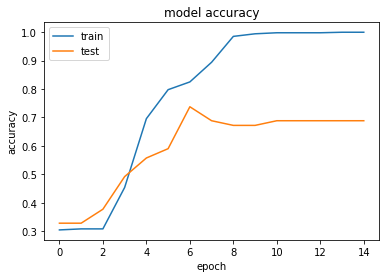

In [21]:
plot_hisory(history.history)